## Project 02: Bayesian learning for classifying news text articles

### Name: Tanusree Debi,Id: 1001838957

#### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import operator

#### Extracting the 20 newsgroups dataset

In [2]:
import tarfile
tar = tarfile.open("20_newsgroups.tar.gz")
tar.extractall()
tar.close()

#### Creating path in directory

In [3]:
my_path = [f for f in os.listdir('./20_newsgroups') if not f.startswith('.')]

#### 20 newsgroups in directory

In [4]:
my_path

['talk.politics.mideast',
 'rec.autos',
 'comp.sys.mac.hardware',
 'alt.atheism',
 'rec.sport.baseball',
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.med',
 'talk.politics.misc',
 'rec.motorcycles',
 'comp.windows.x',
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'sci.electronics',
 'talk.politics.guns',
 'sci.space',
 'soc.religion.christian',
 'misc.forsale',
 'talk.religion.misc']

#### Importing stop_word dataset for deleting them

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanusreedebi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [7]:
redundant_words = [ '--', '|>', '>>', '93', 'xref', 'cantaloupe.srv.cs.cmu.edu', '20', '16', "max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'", '21', '19', '10', '17', '24', 'reply-to:', 'thu', 'nntp-posting-host:', 're:','25''18'"i'd"'>i''22''fri,''23''>the','references:','xref:','sender:','writes:','1993','organization:','newsgroups', 'xref', 'path', 'from', 'subject', 'sender','organisation', 'apr','gmt',  'last','better','never','every','even','two','good','used','first','need','going','must','really','might','well','without','made','give','look','try','far','less','seem','new','make','many','way','since','using','take','help','thanks','send','free','may','see','much','want','find','would','one','like','get','use','also','could','say','us','go','please','said','set','got','sure'
                   ,'come','lot','seems','able','anything','put',]

#### Delete all stop_words,redundant words and punctuations

In [8]:
dictionary = {}
punctuations = ['!','(',')','-','[]','{}',';',':','"','\',']
for m in range(len(my_path)):
    files = os.listdir('./20_newsgroups/' + my_path[m])
    for n in range(len(files)):
        path_of_file = './20_newsgroups/' + my_path[m] + '/' + files[n]
        t = open(path_of_file, 'r', errors='ignore').read() 
        for word in t.split():
            if len(word) != 1: 
               
                if not word.lower() in stop_words:
                    if not word.lower() in redundant_words:     
                        
                        if dictionary.get(word.lower()) != None:
                            dictionary[word.lower()] += 1
                        else:
                            dictionary[word.lower()] = 1

#### Plot a curve word vs. frequency

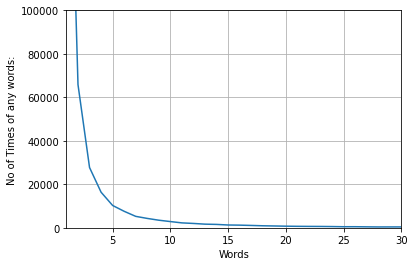

In [9]:
import matplotlib.pyplot as plt
num_words = [0 for i in range(max(dictionary.values())+1)] 
freq = [i for i in range(max(dictionary.values())+1)] 
for key in dictionary:
    num_words[dictionary[key]]+=1
plt.plot(freq,num_words)
plt.axis([1, 30, 0, 100000])
plt.xlabel("Words")
plt.ylabel("No of Times of any words:")
plt.grid()
plt.show()

#### Fix a thresold value for selecting top frequent words

In [10]:
threshold_freq = 100
num_words_above_threshold = len(dictionary)-sum(num_words[0:threshold_freq]) 
print("Number of words({}) :".format(threshold_freq),num_words_above_threshold)

Number of words(100) : 4692


#### Put the top 2000 words in directory

In [11]:
import operator
vocabulary = sorted(dictionary.items(), key= operator.itemgetter(1), reverse= True)
features_dictionary={}
sorted_list = vocabulary[2000][1]
for f in vocabulary:
    features_dictionary[f[0]] = f[1]   
    if f[1] <= sorted_list:
        break

#### Convert the dirrectory into dataframe

In [12]:
features_list = list(features_dictionary.keys())
df = pd.DataFrame(columns = features_list)
for i in range(len(my_path)):
    
    files = os.listdir('./20_newsgroups/' + my_path[i])
 
    for j in range(len(files)):
        
        df.loc[len(df)] = np.zeros(len(features_list))
         
        path = './20_newsgroups/' + my_path[i] + '/' + files[j] 
        text = open(path, 'r', errors='ignore').read()   
        for word in text.split():
            if word.lower() in features_list:
                df[word.lower()][len(df)-1] += 1

In [13]:
x = df.values
feat_list = list(df)

In [14]:
y = []
for i in range(len(my_path)):    
    files = os.listdir('./20_newsgroups/' + my_path[i])
    for f in range(len(files)):
        y.append(i)
y = np.array(y)

#### Split the dataset 50% train and 50%test daatset

In [15]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.5, random_state = 0)

#### Build a funtion to calculate the word according to a given class and calculate total words in a class also

In [16]:
def count(x_train,y_train):

    dict01={}
    
    class_set = set(y_train)
    for class_no in class_set:       
        dict01[class_no]={}
        dict01["total_datavalue"]=len(y_train)
        
        class_row=(y_train==class_no)
        x_train_rows=x_train[class_row]
        y_train_rows=y_train[class_row]
        
        sums=0
        for i in range(len(feat_list)):
            dict01[class_no][feat_list[i]]=x_train_rows[:,i].sum()
            sums=sums + dict01[class_no][feat_list[i]]
            
        dict01[class_no]["total sum"]=sums
        
        
    return dict01

In [17]:
d=count(x_train,y_train)

#### Calculate the Probability by using Naive Bayes formula

In [18]:
def prior_probability(dictionary_table, test,class_no):
    class_probability = np.log(dictionary_table[class_no]["total sum"]) - np.log(dictionary_table["total_datavalue"])
    total_probability = class_probability 
    
    for i in range(len(test)):
        a=dictionary_table[class_no][feat_list[i]]+1
        b=dictionary_table[class_no]["total sum"]+len(feat_list)      
        word_probability = np.log(a) - np.log(b)    
      
        for j in range(int(test[i])):
            total_probability+= word_probability
        
    return total_probability


#### Choose the class number among 20 class for x_test

In [19]:
def choose_class(directory_table,test):
    n=directory_table.keys()
    class_match= -1
    class_prob= -100
    iteration=True  
    for class_no in n:
        if(class_no == "total_datavalue"):
            continue
            
        class_probability=prior_probability(directory_table,test,class_no)
        
        if(iteration or class_probability > class_prob):
            class_prob=class_probability
            class_match=class_no
            
        iteration= False
    return class_match  

#### Calculate the posterior probability using x_test 

In [20]:
def posterior_probability(directory_table,x_test):
    
    y_pred= []
    for i in range(len(x_test)):
        
        class_prediction = choose_class(directory_table,x_test[i,:]) 

        y_pred.append(class_prediction)
    return y_pred

In [21]:
directory_table=count(x_train,y_train)

#### Predict the class

In [22]:
y_prediction=posterior_probability(directory_table,x_test)

#### Predict the accuracy:

In [23]:
from sklearn.metrics import accuracy_score
print("Accuracy of Text Classfication using Multimonial Naive Bayes from scratch", accuracy_score(y_test, y_prediction))

Accuracy of Text Classfication using Multimonial Naive Bayes from scratch 0.1258125812581258


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.18      0.25      0.21       484
           1       0.10      0.04      0.06       502
           2       0.09      0.04      0.06       504
           3       0.11      0.07      0.08       473
           4       0.05      0.05      0.05       479
           5       0.13      0.01      0.02       509
           6       0.10      0.12      0.11       501
           7       0.17      0.07      0.09       528
           8       0.06      0.02      0.03       501
           9       0.12      0.14      0.13       501
          10       0.09      0.23      0.13       501
          11       0.12      0.14      0.13       488
          12       0.11      0.08      0.09       519
          13       0.14      0.06      0.08       504
          14       0.07      0.08      0.08       482
          15       0.19      0.09      0.12       517
          16       0.11      0.02      0.04       504
          17       0.22    

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
cf_matrix = confusion_matrix(y_test,y_prediction)

In [28]:
cf_matrix

array([[121,   5,   4,  12,  16,   2,  29,   4,   5,  43,  64,  12,  15,
          0,  14,   7,   7,  27,  82,  15],
       [ 16,  22,  16,  13,  32,   5,  33,  12,   8,  21,  80,  20,  18,
         18,  30,  14,   5,  18, 108,  13],
       [ 10,  12,  22,   9,  17,   5,  28,   9,  10,   4,  45,  33,  32,
         23,  57,   3,   5,  19, 154,   7],
       [ 41,   9,   5,  32,  30,   2,  32,   7,   8,  65,  62,  15,   5,
          1,  10,  11,   6,  67,  48,  17],
       [ 16,  13,   5,  13,  23,   1,  42,  15,   8,  27,  76,  21,   9,
         10,  29,  19,   8,  29, 102,  13],
       [ 17,  18,  25,   7,  21,   7,  28,  10,  11,  12,  47,  31,  29,
         16,  49,   4,   0,  13, 151,  13],
       [ 28,   3,  10,  14,  34,   6,  59,   8,  13,  26,  54,  31,  22,
          8,  20,   8,   5,  21, 124,   7],
       [ 41,  17,  11,  17,  27,   0,  24,  35,  12,  29,  82,  27,  12,
          8,  23,  24,   7,  33,  84,  15],
       [ 26,  17,  14,  22,  30,   0,  26,   4,  10,  24,  79,  

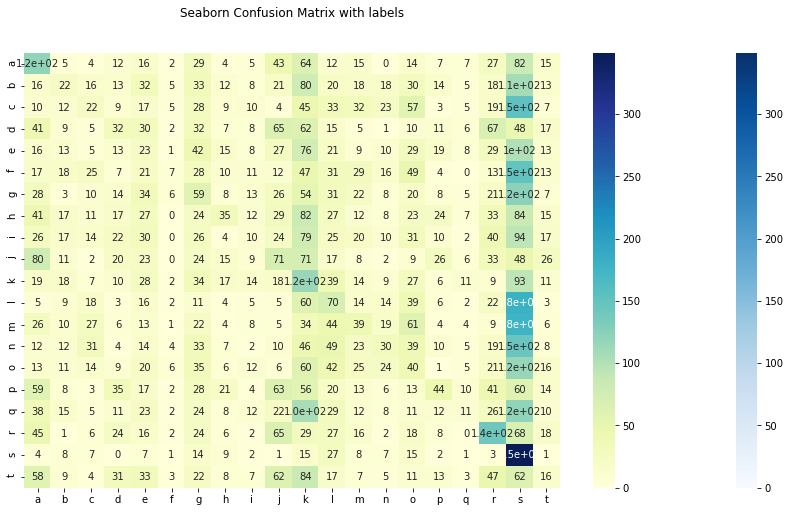

In [29]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,8
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class ');

ax = sns.heatmap(cf_matrix, cmap="YlGnBu")
ax.xaxis.set_ticklabels(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t'])
ax.yaxis.set_ticklabels(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t'])


plt.show()

#### Multinomial Naïve Bayes for Text classification using sklearn.naive_bayes import “MultinomialNB”

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [31]:
acc = MultinomialNB()
acc.fit(x_train, y_train)

MultinomialNB()

In [32]:
Y_predict = acc.predict(x_test)

In [33]:
acc.score(x_test, y_test)

0.12421242124212421

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.20      0.22      0.21       484
           1       0.12      0.04      0.06       502
           2       0.10      0.04      0.06       504
           3       0.09      0.05      0.06       473
           4       0.06      0.05      0.05       479
           5       0.08      0.02      0.04       509
           6       0.09      0.10      0.09       501
           7       0.15      0.07      0.09       528
           8       0.07      0.02      0.03       501
           9       0.12      0.12      0.12       501
          10       0.09      0.25      0.13       501
          11       0.12      0.15      0.14       488
          12       0.10      0.04      0.06       519
          13       0.13      0.06      0.08       504
          14       0.08      0.12      0.09       482
          15       0.19      0.08      0.11       517
          16       0.09      0.02      0.04       504
          17       0.23    

#### Comparing with knn classifier

#### Implementing Text classifier by using KNN classifier:

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

In [36]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [37]:
y_pred = knn.predict(x_test)

In [38]:
knn.score(x_test, y_test)

0.10181018101810181

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.26      0.16       484
           1       0.06      0.11      0.08       502
           2       0.09      0.20      0.12       504
           3       0.07      0.15      0.09       473
           4       0.09      0.08      0.09       479
           5       0.07      0.04      0.05       509
           6       0.09      0.13      0.11       501
           7       0.09      0.04      0.06       528
           8       0.10      0.06      0.08       501
           9       0.14      0.09      0.11       501
          10       0.13      0.07      0.09       501
          11       0.08      0.08      0.08       488
          12       0.10      0.23      0.14       519
          13       0.14      0.04      0.06       504
          14       0.09      0.02      0.03       482
          15       0.13      0.09      0.11       517
          16       0.08      0.02      0.04       504
          17       0.18    